In [1]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [2]:
def Properties(SpecHeat,dTad,B_exp,B_l_int,B_h_int,T,N_ml): #Get the properties on the low and high field

    C_l = zeros([N_ml,len(T)])
    C_h = zeros([N_ml,len(T)])
    dT_l = zeros([N_ml,len(T)])
    dT_h = zeros([N_ml,len(T)])
    
    A_2 = 0
    A_1 = 0
    
    for i in range(K):
        if B_exp[i] == B_l_int and B_exp[i-1]< B_l_int:
            A_2 = np.int(i)  
        if B_exp[i] == B_l_int:
            for j in range(N_ml):
                C_l[j][i-A_2]=C[j,i]
                dT_l[j][i-A_2]=dT[j,i]

        if B_exp[i] == B_h_int and B_exp[i-1]< B_h_int:
            A_1 = np.int(i)
        if B_exp[i] == B_h_int:
            for j in range(N_ml):
                C_h[j][i-A_1]=C[j,i]
                dT_h[j][i-A_1]=dT[j,i]
                
    return(C_l,C_h,dT_l,dT_h)

In [3]:
def SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d):


    C_mag = []
    C_dmag = []
    dT_mag = []
    dT_dmag = []

    T_int = np.arange(Tc,Th+0.001,0.1)

    N_l = len(T_layer)

    A = np.int((Tc - min(T_exp))/0.1)



    T_t = []
    L = 0

    for i in range(N_l):
        L = L + L_layer[i]
        T_tr = Tc + 0.001 +L/100*(Th-Tc)
        T_t.append(T_tr)
    
    
    k = 0    
    for i in range (len(T_int)):
        if T_int[i] <=T_t[k]:
            for j in range(len(T_l)):
                if T_layer[k] >= T_l[j] and T_layer[k] < T_l[j+1]:
                    C_mag.append(C_h[j+1][int(i+A)]-(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j+1][int(i+A)]-(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j+1][int(i+A)]-(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j+1][int(i+A)]-(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_l[j+1]-T_layer[k])/(T_l[j+1]-T_l[j]))
        else:
            for j in range(len(T_l)):
                if T_layer[k+1] >= T_l[j] and T_layer[k+1] < T_l[j+1]:
                    C_mag.append(C_h[j][int(i+A)]+(C_h[j+1][int(i+A)]-C_h[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    C_dmag.append(C_l[j][int(i+A)]+(C_l[j+1][int(i+A)]-C_l[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_mag.append(dT_ad[j][int(i+A)]+(dT_ad[j+1][int(i+A)]-dT_ad[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
                    dT_dmag.append(dT_ad_d[j][int(i+A)]+(dT_ad_d[j+1][int(i+A)]-dT_ad_d[j][int(i+A)])*(T_layer[k+1]-T_l[j])/(T_l[j+1]-T_l[j]))
            k = k + 1
            
    return (C_mag,C_dmag,dT_mag,dT_dmag)

In [4]:
def Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int):
    print(len(C_mag),len(T_int))
    C_mag_mean   = integrate.simps(C_mag,T_int)/(max(T_int)-min(T_int))
    C_dmag_mean  = integrate.simps(C_dmag,T_int)/(max(T_int)-min(T_int))
    
    dT_mag_mean  = integrate.simps(dT_mag,T_int)/(max(T_int)-min(T_int))
    dT_dmag_mean = integrate.simps(dT_dmag,T_int)/(max(T_int)-min(T_int))
    
    CdT_mag_mean   = integrate.simps(np.array(C_mag)*np.array(dT_mag),T_int)/(max(T_int)-min(T_int))
    CdT_dmag_mean  = integrate.simps(np.array(C_dmag)*np.array(dT_dmag),T_int)/(max(T_int)-min(T_int))
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

In [5]:
def Metrics (SpecHeat,dTad,B_l_int,B_h_int,T_arg,N_ml,Th,Tc,T_l,T_layer,L_layer):
    (C_l,C_h,dT_l,dT_h) = Properties(SpecHeat,dTad,B_exp,B_l_int,B_h_int,T_arg,N_ml) #Properties of low and high fields
    dT_ad = np.array(dT_h)-np.array(dT_l)
             
    T_dem = zeros([N_ml,len(T_arg)])
    for j in range(N_ml):
        T_dem[j] = T_arg + dT_ad[j]
             
    dT_ad_d = np.zeros([N_ml,len(T_arg)])
    for i in range(N_ml):
        for j in range(len(T_arg)):
            for k in range(len(T_dem[i])):
                if  T_arg[j] > T_dem[i][k] and T_arg[j] <= T_dem[i][k+1]:
                    dT_ad_d[i][j] = (dT_ad[i][k] + (T_arg[j] - T_dem[i][k])*(dT_ad[i][k+1]-dT_ad[i][k])/(T_arg[k+1]-T_arg[k]))

    (C_mag,C_dmag,dT_mag,dT_dmag) = SubMetrics(Th,Tc,T_l,T_layer,L_layer,C_h,C_l,dT_ad,dT_ad_d)
    
    T_int = np.arange(Tc,Th+0.001,0.1)
    
    C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean = Parameters(C_mag,C_dmag,dT_mag,dT_dmag,T_int)
    
    return C_mag_mean, C_dmag_mean, dT_mag_mean,dT_dmag_mean,CdT_mag_mean,CdT_dmag_mean

Constant inputs

In [6]:
##Properties of the solid 

rho_s = 7900  #[kg/m3] Density of the solid
k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

## Propertis of the fluid

rho_f = 1000  #[kg/m3] Density of the fluid
c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
Pr_f  = 6.136 #[-] Prandtl of the fluid
mu_f  = 0.0008901 #[kg/m-2] #Viscosity of the fluid
k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

## Porous medium
#d_p = 512.5*10**(-6) #[m] Particle diameter
Epsilon = 0.36  #[-] Porosity

Properties Calculation

In [7]:
Prop = xlrd.open_workbook('Gd-Y.xlsx') #Import Properties File
SpecHeat = Prop.sheet_by_name('C') # #Import Specific Heat
dTad = Prop.sheet_by_name('dT') #Import Adiabatic Temperature Change

T_exp = dTad.col_values(0) #Import experimented temperatures 
B_exp = dTad.col_values(1) #Import experimented magnetic fields

T_arg = arange(min(T_exp),max(T_exp)+0.01,0.1)

K = len(dTad.col_values(0)) #Import data number

T_l =  [273,277,283,290]#arange(270,315,2)#Temperature  of Curie of the multilayer
N_ml = len(T_l) #Number of Multilayer Layers


dT = zeros([N_ml,K])
C = zeros([N_ml,K])
for i in range(N_ml):
    dT[i,:] = (dTad.col_values(i+2))    #Data of Adiabatic Temperature change
    C[i,:] = (SpecHeat.col_values(i+2)) #Data of specific heat

In [17]:
T_layer = [289.9,289.9]
L_layer = [50,50]
Nr = 1

Importing AMR simulation inputs

In [166]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0))/1000 #Import AMR Length [mm]
H   = array(Inputs.col_values(1))/1000 #Import AMR Height [mm]
W   = array(Inputs.col_values(2))/1000 #Import AMR Width [mm]
T_h = array(Inputs.col_values(3)) #Import temperature span [K]
T_c = array(Inputs.col_values(4)) #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
B_l   = array(Inputs.col_values(6)) #Import magnetic field [T]
f   = array(Inputs.col_values(7)) #Import frequency [Hz]
m_f = array(Inputs.col_values(8))/3600 #Import mass flow rate [kg/h]
FE = array(Inputs.col_values(9)) #Import mass flow rate [kg/h]

Q_c = array(Inputs.col_values(10)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(11)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(12)) #Import Pumping power [W]
d_p = array(Inputs.col_values(13))/1000 #Import Magnetic power [W]

Calculation

In [167]:
#Porous medium
m_s   = L*W*H*(1-Epsilon)*rho_s #mass of the AMR
Beta = (1-Epsilon)*6/d_p
v_s   = (m_f)/(rho_f*W*H) #Superficial velocity
dP = L*(150*(1-Epsilon)**2/(Epsilon**3)*(mu_f*v_s)/d_p**2 + 1.75*(1-Epsilon)/Epsilon**3*rho_f*v_s**2/d_p)
W_pump = 5*dP*m_f/rho_f


#Dimensionless Numbers
Re_dp = d_p*v_s*rho_f/((1-Epsilon)*mu_f) #Reynolds number
Nu = 2*(1+4*(1-Epsilon)/Epsilon)+((1-Epsilon)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
Pe = Re_dp*Pr_f

h_int = Nu*k_f/d_p

#Effective conduction
k_e_f = k_f*Epsilon #Fluid effective conduction


a_0 = exp(-1.084-6.778*(Epsilon-0.298))
f_0 = 0.8
k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

D_ = (k_f*rho_f/c_f)*0.75*Pe/2

k_s_eff = k_e_s
k_f_eff = k_e_f + rho_f*c_f*D_

In [168]:
C_H = zeros(len(L))
C_L = zeros(len(L))
dT_mg = zeros(len(L))
dT_dmg = zeros(len(L))
CdT_mg = zeros(len(L))
CdT_dmg = zeros(len(L))

In [169]:
for i in range(len(L)):
    print(i)
    C_H[i],C_L[i],dT_mg[i],dT_dmg[i],CdT_mg[i],CdT_dmg[i] = Metrics (SpecHeat,dTad,B_l[i],B[i],T_arg,N_ml,T_h[i],T_c[i],T_l,T_layer,L_layer)

0
25 25
1
99 99
2
158 158
3
176 176
4
190 190
5
188 188
6
184 184
7
177 177
8
168 168
9
160 160
10
150 150
11
2 2
12
113 113
13
159 159
14
186 186
15
11 11
16
106 106
17
161 161
18
192 192
19
3 3
20
86 86
21
143 143
22
174 174
23
16 16
24
127 127
25
154 154
26
10 10
27
115 115
28
145 145


Porous Medium Eff

In [170]:
NTU_f  = h_int*Beta*(L*W*H*10**(-9))/(m_f/3600*c_f) 
#NTU_HB = h_int*Beta*(L*W*H*10**(-9))/(m_s*C_H*f)
#NTU_CB = h_int*Beta*(L*W*H*10**(-9))/(m_s*C_L*f)

Eff = Data.sheet_by_name('Eff') 

Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)

Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

Model Parameters - Similarity

In [171]:
Pi_1 = k_s_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_2 = Epsilon/(1-Epsilon)*k_f_eff*(T_h-T_c)/(rho_s*f*L**2*CdT_dmg)
Pi_3 = W_p/(m_s*f*CdT_dmg)
Pi_4 = CdT_mg/CdT_dmg
Pi_5 = h_int*Beta/(f*rho_s*CdT_dmg) #dT_sf unknown
Pi_6 = ((m_f/3600)*c_f)/(m_s*C_L*f)
Pi_7 = (T_h-T_c)/(dT_dmg)

Pi_8 = Q_c/(m_s*f*CdT_dmg)
Pi_9 = Q_h/(m_s*f*CdT_dmg)
#Pi_10 = W_m/(m_s*f*CdT_dmg)

Efness_HB = zeros(len(Pi_6))
Efness_CB = zeros(len(Pi_6))

for i in range(len(Pi_6)):
    Efness_HB[i] = Effectiv(Pi_6[i]/2,NTU_f[i])
    Efness_CB[i] = Effectiv(Pi_6[i]/(2*Pi_4[i]),NTU_f[i])

Model Parameters - Integral

In [172]:
Q_c

array([ 8.33333333,  8.33333333,  8.33333333,  8.33333333,  8.33333333,
        8.33333333,  8.33333333,  8.33333333,  8.33333333,  8.33333333,
        8.33333333, 26.29166667, 16.66666667,  8.33333333,  4.16666667,
       24.625     , 16.66666667,  8.33333333,  4.16666667, 21.66666667,
       16.66666667,  8.33333333,  4.16666667, 16.66666667,  8.33333333,
        4.16666667, 15.41666667,  8.33333333,  4.16666667])

In [205]:
Q_pas_CB = FE*Efness_CB*(T_h - T_c)*m_f*c_f
Q_act_CB = FE*dT_mg*m_f*c_f
Q_span = FE*(T_h - T_c)*m_f*c_f
Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(T_h-T_c)/L
W_mag  = m_s*f*(CdT_mg - CdT_dmg)
Q_loss = 20*f

In [206]:
CdT_mg-CdT_dmg

array([0.45810769, 0.96399905, 2.08371995, 2.70390216, 3.26198747,
       3.22858345, 3.04298367, 2.74458424, 2.40517635, 2.14321555,
       1.86097475, 0.52213823, 1.65948195, 3.12765572, 4.65328042,
       0.56511647, 1.51858461, 3.21894457, 5.09338897, 0.52856086,
       1.1902687 , 2.48978586, 3.89279271, 0.5824774 , 1.99812973,
       2.91006617, 0.55131294, 1.70286972, 2.5610327 ])

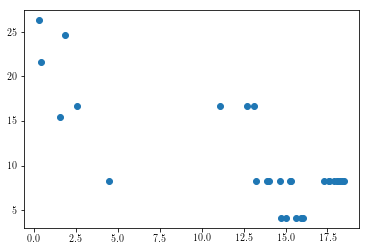

In [207]:
plt.plot(Pi_7,Q_c,'o')

In [208]:
def fitting(X,a,b,c,d): 
    P1,P2= X
    return ((a*(P1**b)+c*(P1*P2)**(d)))

In [209]:
def fit_int(X,a,b,c,d,e,f): 
    P1,P2,P3,P4,P5,P6= X
    return (a*(P1)+b*(P2)+c*(P3)+d*(P4)+e*P5+f*P6)

In [210]:
Coef = curve_fit(fit_int,(Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump,Q_loss),Q_c,maxfev=10000)
Coef

(array([ 3.93839235e-01,  1.83781614e+00, -4.80663288e-01, -3.62747705e+00,
         2.88905669e+01,  1.80811497e-02]),
 array([[-1.31794777e+11, -5.45401171e+04,  1.26562526e+11,
         -6.46868478e+04,  5.44285246e+05,  2.65027984e+02],
        [-5.45401055e+04,  3.51492167e+00,  5.23747965e+04,
         -1.93439272e+00, -4.05713332e+01,  1.42047284e-02],
        [ 1.26562526e+11,  5.23748076e+04, -1.21537995e+11,
          6.21187865e+04, -5.22676464e+05, -2.54506315e+02],
        [-6.46868482e+04, -1.93439273e+00,  6.21187869e+04,
          3.88833992e+00,  2.85320741e+01, -3.70028071e-02],
        [ 5.44285145e+05, -4.05713332e+01, -5.22676367e+05,
          2.85320741e+01,  5.06203404e+02, -2.65154018e-01],
        [ 2.65027938e+02,  1.42047284e-02, -2.54506271e+02,
         -3.70028072e-02, -2.65154018e-01,  4.90134934e-04]]))

In [211]:
Error_bar = np.arange(1,30,1)

In [212]:
Erro = np.abs(Q_c - fit_int((Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3],Coef[0][4]))/Q_c*100

TypeError: fit_int() missing 1 required positional argument: 'f'

Text(0, 0.5, 'Integral Model Cooling Capacity [W]')

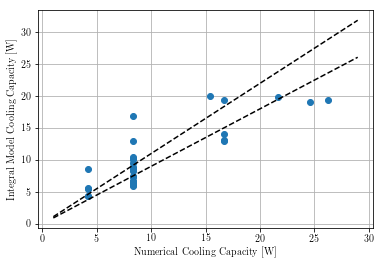

In [213]:
plt.plot(Q_c,fit_int((Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump,Q_loss),Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3],Coef[0][4],Coef[0][5]),'o')
plt.plot(Error_bar,1.1*Error_bar,'k--')
plt.plot(Error_bar,0.9*Error_bar,'k--')
plt.grid()
plt.xlabel('Numerical Cooling Capacity [W]')
plt.ylabel('Integral Model Cooling Capacity [W]')

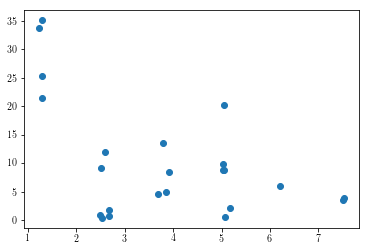

In [165]:
plt.plot(Q_c, Erro,'o')
#plt.ylim(0,50)